In [21]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings

WORKING_DIR = 'C:/term_project/'
os.chdir(WORKING_DIR)
print(os.getcwd())

C:\term_project


In [22]:
# IMPORTS & ENV VARS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Models
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid

# TensorFlow/Keras for CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

DATA_DIR = os.path.join(WORKING_DIR, 'data')
RESULT_DIR = os.path.join(WORKING_DIR, 'results')

# Feature Engineering Parameters
LAG_WEEKS = [4, 8, 12, 16, 20, 24, 28, 32, 36, 41, 52]
ROLLING_WEEKS = [4, 8, 12, 16, 20, 24, 28, 32, 36, 41, 52]
DELTA_WEEKS = [1, 2, 3, 4, 8, 12, 16, 20, 24, 28, 32, 36, 41, 52]

# Split Ratios (No Oversampling)
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15

# XGBoost Parameter Grid
XGB_PARAM_GRID = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100, 150],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# SVM Parameter Grid
SVM_PARAM_GRID = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'epsilon': [0.01, 0.1, 0.5]
}

# CNN Parameters
CNN_EPOCHS = 100
CNN_BATCH_SIZE = 32

# Random Forest (Ensembler) Parameters
RF_PARAM_GRID = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}

print("All imports successful!")

All imports successful!


In [23]:
# LOAD TRAIN DATA

train_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_train.csv'), index_col=[0, 1, 2])
train_labels = pd.read_csv(os.path.join(DATA_DIR, 'dengue_labels_train.csv'), index_col=[0, 1, 2])

# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

print("San Juan")
print("features: ", sj_train_features.shape)
print("labels  : ", sj_train_labels.shape)

print("\nIquitos")
print("features: ", iq_train_features.shape)
print("labels  : ", iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


In [24]:
print("San Juan Features:", sj_train_features.columns.tolist())
print("San Juan Labels:", sj_train_labels.columns.tolist())

San Juan Features: ['week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm']
San Juan Labels: ['total_cases']


In [25]:
# PREPROCESS DATA 

def preprocess_city_data(features, labels=None):
    """
    Merges features and labels, converts week_start_date to index,
    and handles missing values.
    """
    # 1. Merge features and labels if labels are provided
    if labels is not None:
        df = features.join(labels)
    else:
        df = features.copy()
    
    # 2. Reset index to move 'year' and 'weekofyear' from index to columns
    # This preserves them as features.
    df.reset_index(inplace=True)
    
    # 3. Convert week_start_date to datetime
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    
    # 4. Set week_start_date as index
    df.set_index('week_start_date', inplace=True)
    
    # 5. Drop 'city' column as it's constant for each model and not numeric
    if 'city' in df.columns:
        df.drop(columns=['city'], inplace=True)
    
    # 6. Fill Missing Values (Forward Fill for time series)
    df = df.ffill()
    
    return df

# Apply to San Juan and Iquitos
sj_train = preprocess_city_data(sj_train_features, sj_train_labels)
iq_train = preprocess_city_data(iq_train_features, iq_train_labels)

print("San Juan Preprocessed Shape:", sj_train.shape)
print("Iquitos Preprocessed Shape:", iq_train.shape)
sj_train.head()

San Juan Preprocessed Shape: (936, 23)
Iquitos Preprocessed Shape: (520, 23)


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1990-05-07,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
1990-05-14,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
1990-05-21,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
1990-05-28,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [26]:
# FEATURE EXTRACTION

def create_features(df, lag_weeks=LAG_WEEKS, rolling_weeks=ROLLING_WEEKS, delta_weeks=DELTA_WEEKS):
    """
    Creates lag and rolling window features.
    """
    df_eng = df.copy()
    
    # List of columns to create features for (exclude labels and non-numeric if any)
    # Typically climate variables
    feature_cols = [c for c in df.columns if c not in ['total_cases', 'year', 'weekofyear']]
    
    new_features = []
    
    for col in feature_cols:
        # Lag features
        for lag in lag_weeks:
            new_features.append(
                df_eng[col].shift(lag).rename(f'{col}_lag_{lag}')
            )

        # Delta features
        for delta in delta_weeks:
            new_features.append(
                (df_eng[col] - df_eng[col].shift(delta)).rename(f'{col}_delta_{delta}')
            )
            
        # Rolling features
        for window in rolling_weeks:
            rolling_col = df_eng[col].rolling(window=window)
            
            new_features.append(rolling_col.mean().rename(f'{col}_rolling_mean_{window}'))
            new_features.append(rolling_col.std().rename(f'{col}_rolling_std_{window}'))
            new_features.append(rolling_col.var().rename(f'{col}_rolling_var_{window}'))
            new_features.append(rolling_col.min().rename(f'{col}_rolling_min_{window}'))
            new_features.append(rolling_col.max().rename(f'{col}_rolling_max_{window}'))
            new_features.append(rolling_col.median().rename(f'{col}_rolling_median_{window}'))
            new_features.append(rolling_col.skew().rename(f'{col}_rolling_skew_{window}'))
            new_features.append(rolling_col.kurt().rename(f'{col}_rolling_kurt_{window}'))

        # # Z-Score features
        # for window in rolling_weeks:
        #     rolling_mean = df_eng[col].rolling(window=window).mean()
        #     rolling_std = df_eng[col].rolling(window=window).std()
        #     z_score = ((df_eng[col] - rolling_mean) / rolling_std).rename(f'{col}_zscore_{window}')
        #     new_features.append(z_score)
            
    # Concatenate all new features at once to avoid PerformanceWarning (fragmentation)
    if new_features:
        df_features = pd.concat(new_features, axis=1)
        df_eng = pd.concat([df_eng, df_features], axis=1)
            
    # Drop rows with NaNs created by lag/rolling (or fill them)
    # For training, we usually drop the initial rows.
    df_eng.dropna(inplace=True)
    
    return df_eng

# Create engineered features
sj_train_eng = create_features(sj_train)
iq_train_eng = create_features(iq_train)

print("San Juan Engineered Shape:", sj_train_eng.shape)
print("Iquitos Engineered Shape:", iq_train_eng.shape)

San Juan Engineered Shape: (884, 2283)
Iquitos Engineered Shape: (468, 2283)


In [27]:
# LOAD SELECTED FEATURES

sj_selected_features_path = os.path.join(RESULT_DIR, 'sj_selected_features.json')
with open(sj_selected_features_path, 'r') as f:
    sj_features_selected = json.load(f)
    
iq_selected_features_path = os.path.join(RESULT_DIR, 'iq_selected_features.json')
with open(iq_selected_features_path, 'r') as f:
    iq_features_selected = json.load(f)

# Filter engineered data to selected features only
sj_train_eng = sj_train_eng[sj_features_selected + ['total_cases']]
iq_train_eng = iq_train_eng[iq_features_selected + ['total_cases']]

In [28]:
# SPLIT DATA (NO OVERSAMPLING)

def split_data(df, target_col='total_cases', train_ratio=TRAIN_RATIO, val_ratio=VAL_RATIO):
    """
    Splits data into Train, Validation, and Test sets.
    No oversampling - clean time series split.
    """
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    # Split
    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]
    
    # Separate X and y
    X_train = train.drop(columns=[target_col])
    y_train = train[target_col]
    
    X_val = val.drop(columns=[target_col])
    y_val = val[target_col]
    
    X_test = test.drop(columns=[target_col])
    y_test = test[target_col]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

print("Splitting San Juan...")
X_train_sj, y_train_sj, X_val_sj, y_val_sj, X_test_sj, y_test_sj = split_data(sj_train_eng)

print("Splitting Iquitos...")
X_train_iq, y_train_iq, X_val_iq, y_val_iq, X_test_iq, y_test_iq = split_data(iq_train_eng)

print("\nSan Juan Shapes (Train/Val/Test):", X_train_sj.shape, X_val_sj.shape, X_test_sj.shape)
print("Iquitos Shapes (Train/Val/Test):", X_train_iq.shape, X_val_iq.shape, X_test_iq.shape)

Splitting San Juan...
Splitting Iquitos...

San Juan Shapes (Train/Val/Test): (618, 17) (133, 17) (133, 17)
Iquitos Shapes (Train/Val/Test): (327, 24) (70, 24) (71, 24)


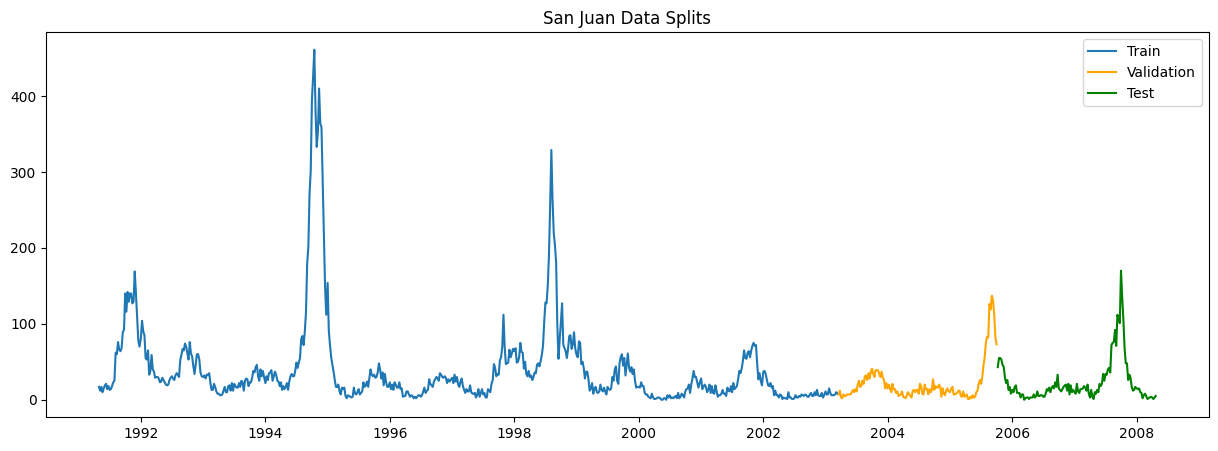

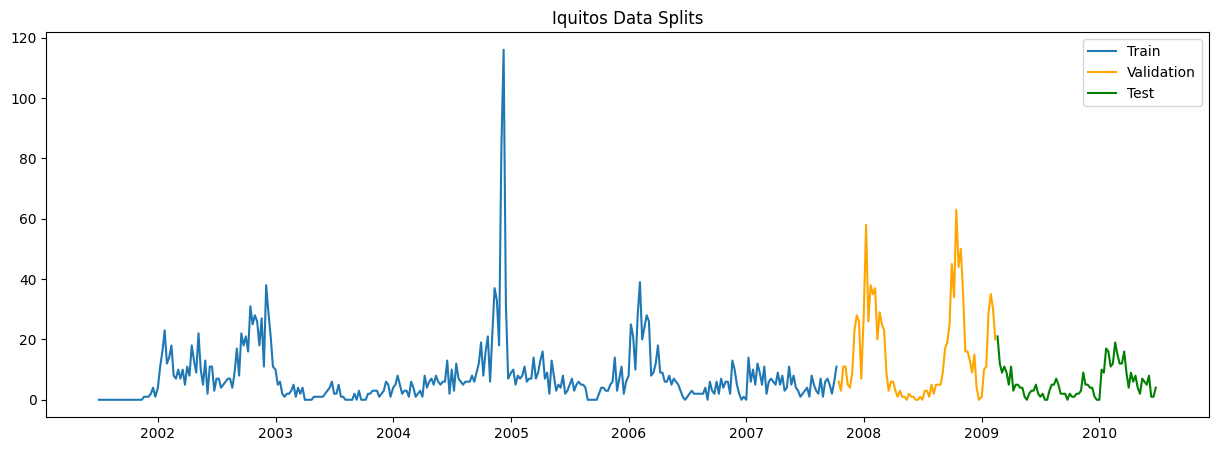

In [29]:
# VISUALIZE SPLITS

def plot_splits(y_train, y_val, y_test, title):
    plt.figure(figsize=(15, 5))
    plt.plot(y_train.index, y_train, label='Train')
    plt.plot(y_val.index, y_val, label='Validation', color='orange')
    plt.plot(y_test.index, y_test, label='Test', color='green')
    plt.title(title)
    plt.legend()
    plt.show()

plot_splits(y_train_sj, y_val_sj, y_test_sj, "San Juan Data Splits")
plot_splits(y_train_iq, y_val_iq, y_test_iq, "Iquitos Data Splits")

In [30]:
# SCALE DATA (Required for SVM and CNN)

# Create scalers for each city
scaler_sj = StandardScaler()
scaler_iq = StandardScaler()

# Fit on training data only, transform all sets
X_train_sj_scaled = scaler_sj.fit_transform(X_train_sj)
X_val_sj_scaled = scaler_sj.transform(X_val_sj)
X_test_sj_scaled = scaler_sj.transform(X_test_sj)

X_train_iq_scaled = scaler_iq.fit_transform(X_train_iq)
X_val_iq_scaled = scaler_iq.transform(X_val_iq)
X_test_iq_scaled = scaler_iq.transform(X_test_iq)

# Convert to DataFrames for XGBoost (keeps column names)
X_train_sj_scaled_df = pd.DataFrame(X_train_sj_scaled, index=X_train_sj.index, columns=X_train_sj.columns)
X_val_sj_scaled_df = pd.DataFrame(X_val_sj_scaled, index=X_val_sj.index, columns=X_val_sj.columns)
X_test_sj_scaled_df = pd.DataFrame(X_test_sj_scaled, index=X_test_sj.index, columns=X_test_sj.columns)

X_train_iq_scaled_df = pd.DataFrame(X_train_iq_scaled, index=X_train_iq.index, columns=X_train_iq.columns)
X_val_iq_scaled_df = pd.DataFrame(X_val_iq_scaled, index=X_val_iq.index, columns=X_val_iq.columns)
X_test_iq_scaled_df = pd.DataFrame(X_test_iq_scaled, index=X_test_iq.index, columns=X_test_iq.columns)

print("Scaling complete!")
print("San Juan scaled shape:", X_train_sj_scaled.shape)
print("Iquitos scaled shape:", X_train_iq_scaled.shape)

Scaling complete!
San Juan scaled shape: (618, 17)
Iquitos scaled shape: (327, 24)


In [31]:
# ===== MODEL 1: XGBOOST =====

def tune_xgboost(X_train, y_train, X_val, y_val):
    """
    Performs Grid Search for XGBoost by training on Train and evaluating on Validation set.
    """
    param_grid = list(ParameterGrid(XGB_PARAM_GRID))
    
    best_score = float('inf')
    best_params = None
    best_model = None
    
    print(f"Tuning XGBoost on {len(param_grid)} combinations...")
    
    for i, params in enumerate(param_grid):
        current_params = params.copy()
        current_params.update({
            'objective': 'reg:squarederror',
            'random_state': 42,
            'n_jobs': -1
        })
        
        model = xgb.XGBRegressor(**current_params)
        model.fit(X_train, y_train, verbose=False)
        
        preds = model.predict(X_val)
        preds = np.maximum(preds, 0)
        mae = mean_absolute_error(y_val, preds)
        
        if mae < best_score:
            best_score = mae
            best_params = params
            best_model = model
    
    print("Best Parameters:", best_params)
    print("Best MAE (Validation):", best_score)
    
    return best_model, best_params

# Tune San Juan XGBoost
print("=" * 50)
print("Tuning San Juan XGBoost Model...")
xgb_model_sj, xgb_params_sj = tune_xgboost(X_train_sj_scaled_df, y_train_sj, X_val_sj_scaled_df, y_val_sj)

# Tune Iquitos XGBoost
print("\n" + "=" * 50)
print("Tuning Iquitos XGBoost Model...")
xgb_model_iq, xgb_params_iq = tune_xgboost(X_train_iq_scaled_df, y_train_iq, X_val_iq_scaled_df, y_val_iq)

Tuning San Juan XGBoost Model...
Tuning XGBoost on 72 combinations...
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}
Best MAE (Validation): 9.162193298339844

Tuning Iquitos XGBoost Model...
Tuning XGBoost on 72 combinations...
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'subsample': 1.0}
Best MAE (Validation): 11.37206745147705


In [32]:
# ===== MODEL 2: SVM (Support Vector Regression) =====

def tune_svm(X_train, y_train, X_val, y_val):
    """
    Performs Grid Search for SVM by training on Train and evaluating on Validation set.
    SVM requires scaled data.
    """
    param_grid = list(ParameterGrid(SVM_PARAM_GRID))
    
    best_score = float('inf')
    best_params = None
    best_model = None
    
    print(f"Tuning SVM on {len(param_grid)} combinations...")
    
    for i, params in enumerate(param_grid):
        current_params = params.copy()
        current_params['kernel'] = 'rbf'
        
        model = SVR(**current_params)
        model.fit(X_train, y_train)
        
        preds = model.predict(X_val)
        preds = np.maximum(preds, 0)
        mae = mean_absolute_error(y_val, preds)
        
        if mae < best_score:
            best_score = mae
            best_params = params
            best_model = model
            
        if (i + 1) % 10 == 0:
            print(f"  Completed {i + 1}/{len(param_grid)} combinations...")
    
    print("Best Parameters:", best_params)
    print("Best MAE (Validation):", best_score)
    
    return best_model, best_params

# Tune San Juan SVM
print("=" * 50)
print("Tuning San Juan SVM Model...")
svm_model_sj, svm_params_sj = tune_svm(X_train_sj_scaled, y_train_sj, X_val_sj_scaled, y_val_sj)

# Tune Iquitos SVM
print("\n" + "=" * 50)
print("Tuning Iquitos SVM Model...")
svm_model_iq, svm_params_iq = tune_svm(X_train_iq_scaled, y_train_iq, X_val_iq_scaled, y_val_iq)

Tuning San Juan SVM Model...
Tuning SVM on 48 combinations...
  Completed 10/48 combinations...
  Completed 20/48 combinations...
  Completed 30/48 combinations...
  Completed 40/48 combinations...
Best Parameters: {'C': 1, 'epsilon': 0.01, 'gamma': 0.01}
Best MAE (Validation): 11.570822515940405

Tuning Iquitos SVM Model...
Tuning SVM on 48 combinations...
  Completed 10/48 combinations...
  Completed 20/48 combinations...
  Completed 30/48 combinations...
  Completed 40/48 combinations...
Best Parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 'auto'}
Best MAE (Validation): 11.081356829036233


In [33]:
# ===== MODEL 3: 1D CNN =====

def build_cnn_model(input_shape):
    """
    Builds a 1D CNN model for time series regression.
    """
    model = Sequential([
        # First Conv Block
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', 
               input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        # Second Conv Block
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        # Third Conv Block
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Flatten and Dense layers
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)  # Regression output
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mae',
        metrics=['mae']
    )
    
    return model

def train_cnn(X_train, y_train, X_val, y_val, epochs=CNN_EPOCHS, batch_size=CNN_BATCH_SIZE):
    """
    Trains a CNN model with early stopping.
    For 1D CNN, we reshape data to (samples, timesteps, features).
    Since we're treating each sample as a single timestep with multiple features,
    we reshape to (samples, features, 1) - treating features as timesteps.
    """
    # Reshape for 1D CNN: (samples, timesteps, channels)
    # Here we treat each feature as a timestep
    X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val_cnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
    
    input_shape = (X_train_cnn.shape[1], 1)
    model = build_cnn_model(input_shape)
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]
    
    history = model.fit(
        X_train_cnn, y_train,
        validation_data=(X_val_cnn, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate
    val_preds = model.predict(X_val_cnn, verbose=0).flatten()
    val_preds = np.maximum(val_preds, 0)
    val_mae = mean_absolute_error(y_val, val_preds)
    print(f"CNN Validation MAE: {val_mae:.4f}")
    
    return model, history

# Train San Juan CNN
print("=" * 50)
print("Training San Juan CNN Model...")
cnn_model_sj, cnn_history_sj = train_cnn(X_train_sj_scaled, y_train_sj.values, 
                                          X_val_sj_scaled, y_val_sj.values)

# Train Iquitos CNN
print("\n" + "=" * 50)
print("Training Iquitos CNN Model...")
cnn_model_iq, cnn_history_iq = train_cnn(X_train_iq_scaled, y_train_iq.values, 
                                          X_val_iq_scaled, y_val_iq.values)

Training San Juan CNN Model...
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 36.1910 - mae: 36.1910 - val_loss: 20.5968 - val_mae: 20.5968 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 26.1277 - mae: 26.1277 - val_loss: 17.0862 - val_mae: 17.0862 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 21.4538 - mae: 21.4538 - val_loss: 15.3041 - val_mae: 15.3041 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 18.8226 - mae: 18.8226 - val_loss: 13.7772 - val_mae: 13.7772 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.7773 - mae: 16.7773 - val_loss: 13.3712 - val_mae: 13.3712 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 15.6757 - mae: 15.6757 - val_loss: 13.9822 - val_mae: 13.9822 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 15.8463 - mae: 15.8463 - val_loss: 13.4

In [34]:
# ===== GENERATE BASE MODEL PREDICTIONS FOR ENSEMBLE =====

def get_base_predictions(xgb_model, svm_model, cnn_model, X_scaled, X_scaled_df):
    """
    Generate predictions from all base models for stacking.
    """
    # XGBoost predictions
    xgb_preds = xgb_model.predict(X_scaled_df)
    xgb_preds = np.maximum(xgb_preds, 0)
    
    # SVM predictions
    svm_preds = svm_model.predict(X_scaled)
    svm_preds = np.maximum(svm_preds, 0)
    
    # CNN predictions
    X_cnn = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))
    cnn_preds = cnn_model.predict(X_cnn, verbose=0).flatten()
    cnn_preds = np.maximum(cnn_preds, 0)
    
    # Stack predictions as features for meta-learner
    stacked_features = np.column_stack([xgb_preds, svm_preds, cnn_preds])
    
    return stacked_features, xgb_preds, svm_preds, cnn_preds

# Get predictions on validation set for training the meta-learner
print("Generating San Juan stacked features...")
sj_val_stacked, sj_val_xgb, sj_val_svm, sj_val_cnn = get_base_predictions(
    xgb_model_sj, svm_model_sj, cnn_model_sj, X_val_sj_scaled, X_val_sj_scaled_df
)

print("Generating Iquitos stacked features...")
iq_val_stacked, iq_val_xgb, iq_val_svm, iq_val_cnn = get_base_predictions(
    xgb_model_iq, svm_model_iq, cnn_model_iq, X_val_iq_scaled, X_val_iq_scaled_df
)

# Get predictions on test set for final ensemble evaluation
print("\nGenerating San Juan test stacked features...")
sj_test_stacked, sj_test_xgb, sj_test_svm, sj_test_cnn = get_base_predictions(
    xgb_model_sj, svm_model_sj, cnn_model_sj, X_test_sj_scaled, X_test_sj_scaled_df
)

print("Generating Iquitos test stacked features...")
iq_test_stacked, iq_test_xgb, iq_test_svm, iq_test_cnn = get_base_predictions(
    xgb_model_iq, svm_model_iq, cnn_model_iq, X_test_iq_scaled, X_test_iq_scaled_df
)

print("\nStacked features shapes:")
print(f"SJ Val: {sj_val_stacked.shape}, SJ Test: {sj_test_stacked.shape}")
print(f"IQ Val: {iq_val_stacked.shape}, IQ Test: {iq_test_stacked.shape}")

Generating San Juan stacked features...
Generating Iquitos stacked features...

Generating San Juan test stacked features...
Generating Iquitos test stacked features...

Stacked features shapes:
SJ Val: (133, 3), SJ Test: (133, 3)
IQ Val: (70, 3), IQ Test: (71, 3)


In [35]:
# ===== RANDOM FOREST META-LEARNER (ENSEMBLER) =====

def tune_random_forest(X_train, y_train, X_test, y_test):
    """
    Tunes Random Forest meta-learner using grid search.
    Training set = validation predictions from base models
    Test set = test predictions from base models
    """
    param_grid = list(ParameterGrid(RF_PARAM_GRID))
    
    best_score = float('inf')
    best_params = None
    best_model = None
    
    print(f"Tuning Random Forest on {len(param_grid)} combinations...")
    
    for params in param_grid:
        model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        
        preds = model.predict(X_test)
        preds = np.maximum(preds, 0)
        mae = mean_absolute_error(y_test, preds)
        
        if mae < best_score:
            best_score = mae
            best_params = params
            best_model = model
    
    print("Best Parameters:", best_params)
    print("Best MAE (Test):", best_score)
    
    return best_model, best_params

# Train Random Forest meta-learner for San Juan
print("=" * 50)
print("Training San Juan Random Forest Ensembler...")
rf_model_sj, rf_params_sj = tune_random_forest(sj_val_stacked, y_val_sj, sj_test_stacked, y_test_sj)

# Train Random Forest meta-learner for Iquitos
print("\n" + "=" * 50)
print("Training Iquitos Random Forest Ensembler...")
rf_model_iq, rf_params_iq = tune_random_forest(iq_val_stacked, y_val_iq, iq_test_stacked, y_test_iq)

Training San Juan Random Forest Ensembler...
Tuning Random Forest on 36 combinations...
Best Parameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}
Best MAE (Test): 14.08033963009185

Training Iquitos Random Forest Ensembler...
Tuning Random Forest on 36 combinations...
Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Best MAE (Test): 8.471157262967266


In [36]:
# ===== ENSEMBLE EVALUATION AND COMPARISON =====

# Evaluate individual models on test set
print("=" * 60)
print("INDIVIDUAL MODEL PERFORMANCE (Test Set)")
print("=" * 60)

# San Juan
print("\n--- San Juan ---")
mae_xgb_sj = mean_absolute_error(y_test_sj, sj_test_xgb)
mae_svm_sj = mean_absolute_error(y_test_sj, sj_test_svm)
mae_cnn_sj = mean_absolute_error(y_test_sj, sj_test_cnn)
print(f"XGBoost MAE: {mae_xgb_sj:.4f}")
print(f"SVM MAE: {mae_svm_sj:.4f}")
print(f"CNN MAE: {mae_cnn_sj:.4f}")

# Iquitos
print("\n--- Iquitos ---")
mae_xgb_iq = mean_absolute_error(y_test_iq, iq_test_xgb)
mae_svm_iq = mean_absolute_error(y_test_iq, iq_test_svm)
mae_cnn_iq = mean_absolute_error(y_test_iq, iq_test_cnn)
print(f"XGBoost MAE: {mae_xgb_iq:.4f}")
print(f"SVM MAE: {mae_svm_iq:.4f}")
print(f"CNN MAE: {mae_cnn_iq:.4f}")

# Ensemble predictions
print("\n" + "=" * 60)
print("ENSEMBLE MODEL PERFORMANCE (Random Forest Meta-Learner)")
print("=" * 60)

# San Juan Ensemble
ensemble_preds_sj = rf_model_sj.predict(sj_test_stacked)
ensemble_preds_sj = np.maximum(ensemble_preds_sj, 0)
mae_ensemble_sj = mean_absolute_error(y_test_sj, ensemble_preds_sj)
print(f"\nSan Juan Ensemble MAE: {mae_ensemble_sj:.4f}")

# Iquitos Ensemble
ensemble_preds_iq = rf_model_iq.predict(iq_test_stacked)
ensemble_preds_iq = np.maximum(ensemble_preds_iq, 0)
mae_ensemble_iq = mean_absolute_error(y_test_iq, ensemble_preds_iq)
print(f"Iquitos Ensemble MAE: {mae_ensemble_iq:.4f}")

# Summary
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"San Juan - Best Individual: {min(mae_xgb_sj, mae_svm_sj, mae_cnn_sj):.4f}, Ensemble: {mae_ensemble_sj:.4f}")
print(f"Iquitos  - Best Individual: {min(mae_xgb_iq, mae_svm_iq, mae_cnn_iq):.4f}, Ensemble: {mae_ensemble_iq:.4f}")

INDIVIDUAL MODEL PERFORMANCE (Test Set)

--- San Juan ---
XGBoost MAE: 16.2156
SVM MAE: 12.7092
CNN MAE: 15.6153

--- Iquitos ---
XGBoost MAE: 4.1594
SVM MAE: 3.6571
CNN MAE: 4.0106

ENSEMBLE MODEL PERFORMANCE (Random Forest Meta-Learner)

San Juan Ensemble MAE: 14.0803
Iquitos Ensemble MAE: 8.4712

SUMMARY
San Juan - Best Individual: 12.7092, Ensemble: 14.0803
Iquitos  - Best Individual: 3.6571, Ensemble: 8.4712


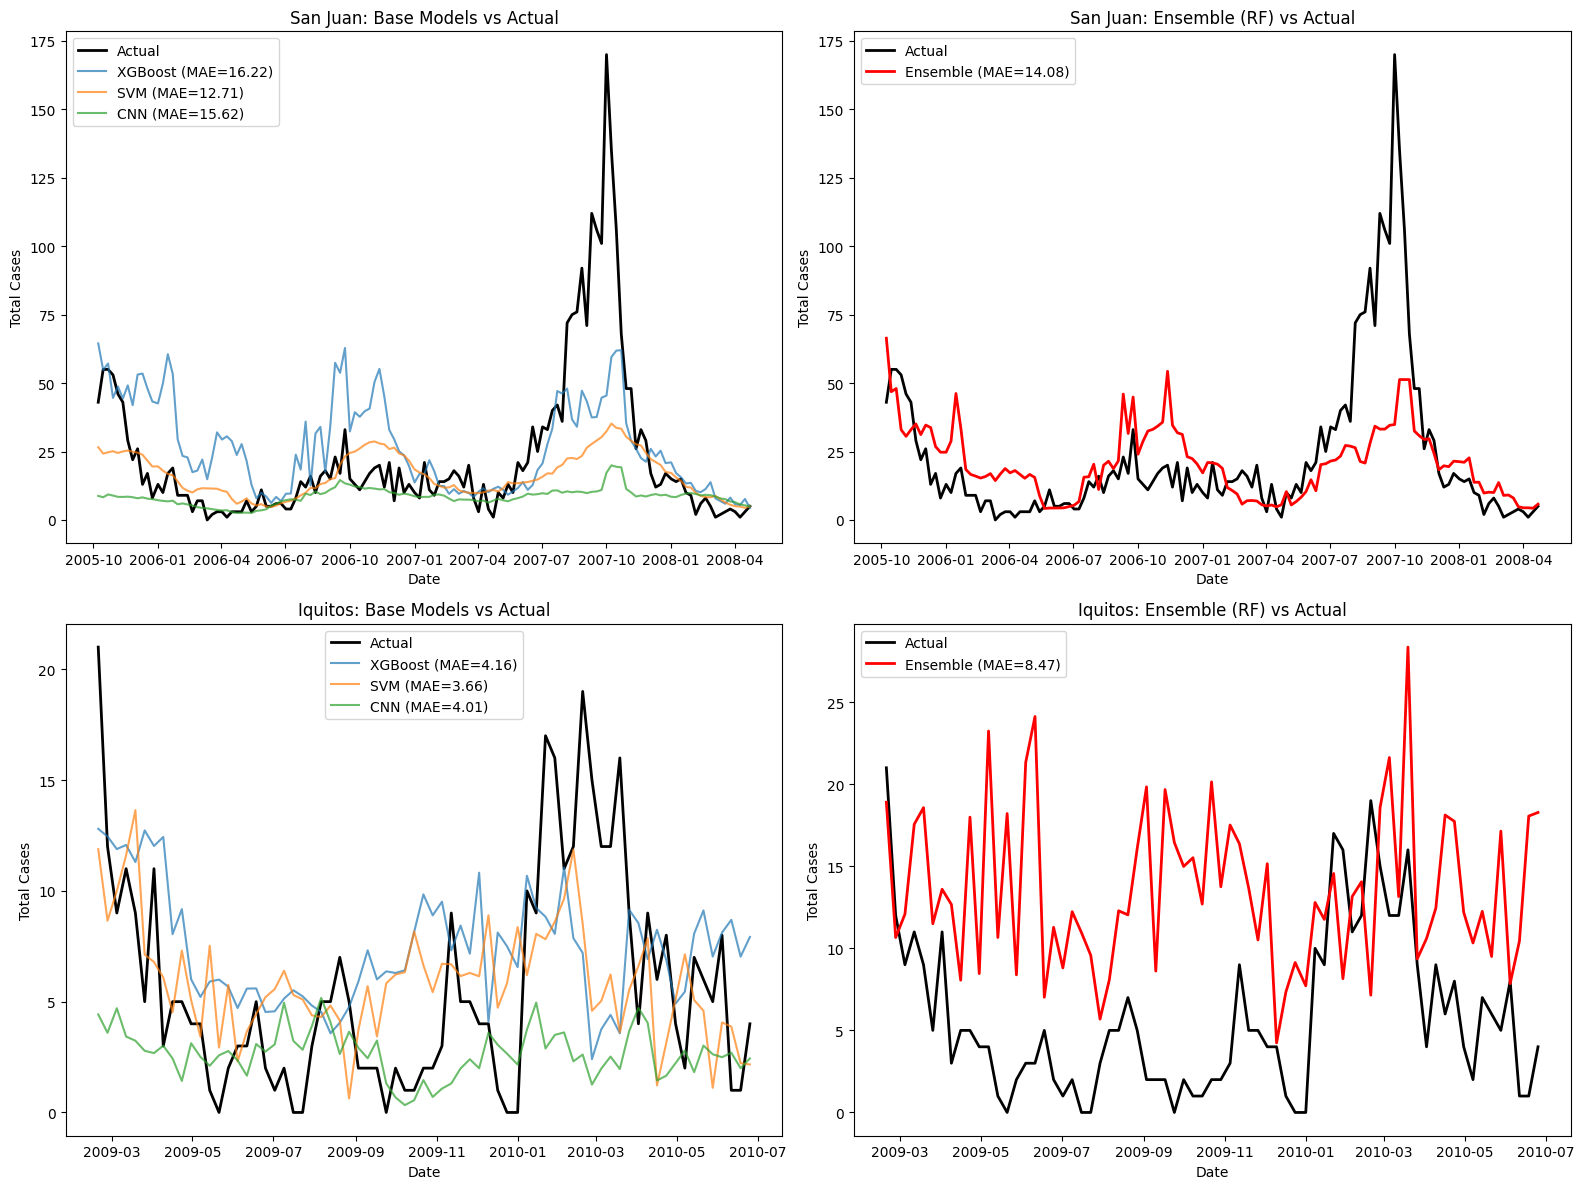

In [37]:
# ===== VISUALIZE ENSEMBLE PREDICTIONS VS ACTUAL =====

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# San Juan - All Models
ax1 = axes[0, 0]
ax1.plot(y_test_sj.index, y_test_sj.values, label='Actual', linewidth=2, color='black')
ax1.plot(y_test_sj.index, sj_test_xgb, label=f'XGBoost (MAE={mae_xgb_sj:.2f})', alpha=0.7)
ax1.plot(y_test_sj.index, sj_test_svm, label=f'SVM (MAE={mae_svm_sj:.2f})', alpha=0.7)
ax1.plot(y_test_sj.index, sj_test_cnn, label=f'CNN (MAE={mae_cnn_sj:.2f})', alpha=0.7)
ax1.set_title('San Juan: Base Models vs Actual')
ax1.legend()
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Cases')

# San Juan - Ensemble
ax2 = axes[0, 1]
ax2.plot(y_test_sj.index, y_test_sj.values, label='Actual', linewidth=2, color='black')
ax2.plot(y_test_sj.index, ensemble_preds_sj, label=f'Ensemble (MAE={mae_ensemble_sj:.2f})', 
         linewidth=2, color='red')
ax2.set_title('San Juan: Ensemble (RF) vs Actual')
ax2.legend()
ax2.set_xlabel('Date')
ax2.set_ylabel('Total Cases')

# Iquitos - All Models
ax3 = axes[1, 0]
ax3.plot(y_test_iq.index, y_test_iq.values, label='Actual', linewidth=2, color='black')
ax3.plot(y_test_iq.index, iq_test_xgb, label=f'XGBoost (MAE={mae_xgb_iq:.2f})', alpha=0.7)
ax3.plot(y_test_iq.index, iq_test_svm, label=f'SVM (MAE={mae_svm_iq:.2f})', alpha=0.7)
ax3.plot(y_test_iq.index, iq_test_cnn, label=f'CNN (MAE={mae_cnn_iq:.2f})', alpha=0.7)
ax3.set_title('Iquitos: Base Models vs Actual')
ax3.legend()
ax3.set_xlabel('Date')
ax3.set_ylabel('Total Cases')

# Iquitos - Ensemble
ax4 = axes[1, 1]
ax4.plot(y_test_iq.index, y_test_iq.values, label='Actual', linewidth=2, color='black')
ax4.plot(y_test_iq.index, ensemble_preds_iq, label=f'Ensemble (MAE={mae_ensemble_iq:.2f})', 
         linewidth=2, color='red')
ax4.set_title('Iquitos: Ensemble (RF) vs Actual')
ax4.legend()
ax4.set_xlabel('Date')
ax4.set_ylabel('Total Cases')

plt.tight_layout()
plt.show()

In [39]:
# ===== RETRAIN ALL MODELS ON FULL TRAINING DATA =====

# Combine train + val + test for final training
# San Juan
X_full_sj = pd.concat([X_train_sj, X_val_sj, X_test_sj])
y_full_sj = pd.concat([y_train_sj, y_val_sj, y_test_sj])

# Iquitos
X_full_iq = pd.concat([X_train_iq, X_val_iq, X_test_iq])
y_full_iq = pd.concat([y_train_iq, y_val_iq, y_test_iq])

# Re-scale full data
scaler_full_sj = StandardScaler()
scaler_full_iq = StandardScaler()

X_full_sj_scaled = scaler_full_sj.fit_transform(X_full_sj)
X_full_sj_scaled_df = pd.DataFrame(X_full_sj_scaled, index=X_full_sj.index, columns=X_full_sj.columns)

X_full_iq_scaled = scaler_full_iq.fit_transform(X_full_iq)
X_full_iq_scaled_df = pd.DataFrame(X_full_iq_scaled, index=X_full_iq.index, columns=X_full_iq.columns)

print("Retraining all base models on full data...")

# Retrain XGBoost
print("\n[1/3] Retraining XGBoost...")
final_xgb_sj = xgb.XGBRegressor(**xgb_model_sj.get_params())
final_xgb_sj.fit(X_full_sj_scaled_df, y_full_sj, verbose=False)

final_xgb_iq = xgb.XGBRegressor(**xgb_model_iq.get_params())
final_xgb_iq.fit(X_full_iq_scaled_df, y_full_iq, verbose=False)

# Retrain SVM
print("[2/3] Retraining SVM...")
final_svm_sj = SVR(kernel='rbf', **svm_params_sj)
final_svm_sj.fit(X_full_sj_scaled, y_full_sj)

final_svm_iq = SVR(kernel='rbf', **svm_params_iq)
final_svm_iq.fit(X_full_iq_scaled, y_full_iq)

# Retrain CNN
print("[3/3] Retraining CNN...")
X_full_sj_cnn = X_full_sj_scaled.reshape((X_full_sj_scaled.shape[0], X_full_sj_scaled.shape[1], 1))
X_full_iq_cnn = X_full_iq_scaled.reshape((X_full_iq_scaled.shape[0], X_full_iq_scaled.shape[1], 1))

callbacks_final = [
    EarlyStopping(monitor='loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)
]

final_cnn_sj = build_cnn_model((X_full_sj_cnn.shape[1], 1))
final_cnn_sj.fit(X_full_sj_cnn, y_full_sj.values, epochs=CNN_EPOCHS, batch_size=CNN_BATCH_SIZE, 
                  callbacks=callbacks_final, verbose=0)

final_cnn_iq = build_cnn_model((X_full_iq_cnn.shape[1], 1))
final_cnn_iq.fit(X_full_iq_cnn, y_full_iq.values, epochs=CNN_EPOCHS, batch_size=CNN_BATCH_SIZE, 
                  callbacks=callbacks_final, verbose=0)

print("\nAll base models retrained on full data!")

Retraining all base models on full data...

[1/3] Retraining XGBoost...
[2/3] Retraining SVM...
[3/3] Retraining CNN...

All base models retrained on full data!


In [40]:
# ===== FINAL PREDICTIONS ON TEST SET AND SUBMISSION =====

# 1. Load Test Data
test_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_test.csv'), index_col=[0, 1, 2])

sj_test_features = test_features.loc['sj']
iq_test_features = test_features.loc['iq']

# 2. Preprocess Test Data
sj_test = preprocess_city_data(sj_test_features)
iq_test = preprocess_city_data(iq_test_features)

# 3. Feature Engineering for Test Data (handling lags)
def prepare_test_features(train_df, test_df, selected_features, rolling_weeks=ROLLING_WEEKS, 
                           lag_weeks=LAG_WEEKS, delta_weeks=DELTA_WEEKS):
    """
    Combines train tail with test to generate features without NaNs in test.
    """
    max_lookback = max(max(rolling_weeks), max(lag_weeks), max(delta_weeks)) + 50
    train_subset = train_df[test_df.columns].tail(max_lookback)
    combined = pd.concat([train_subset, test_df])
    combined_eng = create_features(combined, lag_weeks=lag_weeks, rolling_weeks=rolling_weeks, 
                                   delta_weeks=delta_weeks)
    combined_eng = combined_eng[selected_features]
    test_eng = combined_eng.loc[test_df.index]
    return test_eng

print("Generating Test Features...")
sj_submission_test_eng = prepare_test_features(sj_train, sj_test, sj_features_selected)
iq_submission_test_eng = prepare_test_features(iq_train, iq_test, iq_features_selected)

# Align test features
sj_features_kept = [c for c in X_full_sj.columns]
iq_features_kept = [c for c in X_full_iq.columns]

sj_submission_test_eng = sj_submission_test_eng[sj_features_kept]
iq_submission_test_eng = iq_submission_test_eng[iq_features_kept]

print("San Juan Test Shape:", sj_submission_test_eng.shape)
print("Iquitos Test Shape:", iq_submission_test_eng.shape)

# 4. Scale submission test data
sj_submission_scaled = scaler_full_sj.transform(sj_submission_test_eng)
sj_submission_scaled_df = pd.DataFrame(sj_submission_scaled, index=sj_submission_test_eng.index, 
                                        columns=sj_submission_test_eng.columns)

iq_submission_scaled = scaler_full_iq.transform(iq_submission_test_eng)
iq_submission_scaled_df = pd.DataFrame(iq_submission_scaled, index=iq_submission_test_eng.index, 
                                        columns=iq_submission_test_eng.columns)

# 5. Generate base model predictions for submission
print("\nGenerating base model predictions for submission...")

# XGBoost predictions
sj_sub_xgb = final_xgb_sj.predict(sj_submission_scaled_df)
iq_sub_xgb = final_xgb_iq.predict(iq_submission_scaled_df)

# SVM predictions
sj_sub_svm = final_svm_sj.predict(sj_submission_scaled)
iq_sub_svm = final_svm_iq.predict(iq_submission_scaled)

# CNN predictions
sj_sub_cnn_input = sj_submission_scaled.reshape((sj_submission_scaled.shape[0], sj_submission_scaled.shape[1], 1))
iq_sub_cnn_input = iq_submission_scaled.reshape((iq_submission_scaled.shape[0], iq_submission_scaled.shape[1], 1))

sj_sub_cnn = final_cnn_sj.predict(sj_sub_cnn_input, verbose=0).flatten()
iq_sub_cnn = final_cnn_iq.predict(iq_sub_cnn_input, verbose=0).flatten()

# 6. Stack predictions for ensemble
sj_sub_stacked = np.column_stack([sj_sub_xgb, sj_sub_svm, sj_sub_cnn])
iq_sub_stacked = np.column_stack([iq_sub_xgb, iq_sub_svm, iq_sub_cnn])

# 7. Final ensemble prediction using Random Forest
sj_final_preds = rf_model_sj.predict(sj_sub_stacked)
sj_final_preds = np.maximum(sj_final_preds, 0).astype(int)

iq_final_preds = rf_model_iq.predict(iq_sub_stacked)
iq_final_preds = np.maximum(iq_final_preds, 0).astype(int)

# 8. Create Submission
submission = pd.read_csv(os.path.join(DATA_DIR, "submission_format.csv"), index_col=[0, 1, 2])

# Assign values
submission.loc['sj', 'total_cases'] = sj_final_preds
submission.loc['iq', 'total_cases'] = iq_final_preds

# 9. Save
submission_path = os.path.join(RESULT_DIR, 'submission_ensemble_xgb_svm_cnn_rf.csv')
submission.to_csv(submission_path)
print(f"\nSubmission saved to {submission_path}")
print(f"\nPrediction Summary:")
print(f"San Juan: min={sj_final_preds.min()}, max={sj_final_preds.max()}, mean={sj_final_preds.mean():.2f}")
print(f"Iquitos: min={iq_final_preds.min()}, max={iq_final_preds.max()}, mean={iq_final_preds.mean():.2f}")
submission.head(10)

Generating Test Features...
San Juan Test Shape: (260, 17)
Iquitos Test Shape: (156, 24)

Generating base model predictions for submission...

Submission saved to C:/term_project/results\submission_ensemble_xgb_svm_cnn_rf.csv

Prediction Summary:
San Juan: min=4, max=102, mean=36.14
Iquitos: min=5, max=49, mean=18.37


total_cases
city year weekofyear             
sj   2008 18                    5
          19                    4
          20                    5
          21                    5
          22                    5
          23                    4
          24                    4
          25                    4
          26                    4
          27                    4

In [41]:
# ===== ENSEMBLE MODEL SUMMARY =====
print("=" * 70)
print("ENSEMBLE MODEL ARCHITECTURE")
print("=" * 70)
print("""
┌─────────────────────────────────────────────────────────────────────┐
│                         INPUT FEATURES                               │
│                    (Scaled with StandardScaler)                       │
└───────────────────────────┬─────────────────────────────────────────┘
                            │
        ┌───────────────────┼───────────────────┐
        │                   │                   │
        ▼                   ▼                   ▼
┌───────────────┐   ┌───────────────┐   ┌───────────────┐
│    XGBoost    │   │      SVM      │   │    1D CNN     │
│   Regressor   │   │    (SVR)      │   │   Regressor   │
└───────┬───────┘   └───────┬───────┘   └───────┬───────┘
        │                   │                   │
        └───────────────────┼───────────────────┘
                            │
                            ▼
              ┌─────────────────────────┐
              │     STACKED FEATURES    │
              │ [xgb_pred, svm_pred,    │
              │  cnn_pred]              │
              └───────────┬─────────────┘
                          │
                          ▼
              ┌─────────────────────────┐
              │    Random Forest        │
              │    (Meta-Learner)       │
              └───────────┬─────────────┘
                          │
                          ▼
              ┌─────────────────────────┐
              │   FINAL PREDICTION      │
              │   (total_cases)         │
              └─────────────────────────┘
""")
print("=" * 70)
print("Best Parameters:")
print(f"  XGBoost SJ: {xgb_params_sj}")
print(f"  XGBoost IQ: {xgb_params_iq}")
print(f"  SVM SJ: {svm_params_sj}")
print(f"  SVM IQ: {svm_params_iq}")
print(f"  RF Ensembler SJ: {rf_params_sj}")
print(f"  RF Ensembler IQ: {rf_params_iq}")
print("=" * 70)

ENSEMBLE MODEL ARCHITECTURE

┌─────────────────────────────────────────────────────────────────────┐
│                         INPUT FEATURES                               │
│                    (Scaled with StandardScaler)                       │
└───────────────────────────┬─────────────────────────────────────────┘
                            │
        ┌───────────────────┼───────────────────┐
        │                   │                   │
        ▼                   ▼                   ▼
┌───────────────┐   ┌───────────────┐   ┌───────────────┐
│    XGBoost    │   │      SVM      │   │    1D CNN     │
│   Regressor   │   │    (SVR)      │   │   Regressor   │
└───────┬───────┘   └───────┬───────┘   └───────┬───────┘
        │                   │                   │
        └───────────────────┼───────────────────┘
                            │
                            ▼
              ┌─────────────────────────┐
              │     STACKED FEATURES    │
              │ [xgb_pre

In [42]:
# SUBMISSION SCORE

25.3918

25.3918